##### **Loading Data & Importing Libraries**

In [2]:
# Loading data from SQLite and importing sqlite3 for DB connection and pandas for data handling.

import sqlite3
import pandas as pd
import re                           # for Time conversion
import matplotlib.pyplot as plt     # for Plot Numeric Distributions
import numpy as ny                  # for Dynamic Correlation Heatmap
import seaborn as sns               # for Categorical Feature Correlations (Cramér's V)
from scipy.stats import chi2_contingency # for Categorical Feature Correlations (Cramér's V)


In [3]:
# Connecting to local database file in the data folder.

conn = sqlite3.connect('data/score.db')


In [4]:
# 1. Discover all table names dynamically
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)['name'].tolist()

# 2. Load each table into a dict of DataFrames
dataframes = {
    tbl: pd.read_sql_query(f"SELECT * FROM {tbl};", conn)
    for tbl in tables
}

# 3. Display the top 10 rows for each table without hard‑coding its name
for tbl_name, tbl_df in dataframes.items():
    print(f"\n=== Table: {tbl_name} (first 10 rows) ===")
    display(tbl_df.head(10))



=== Table: score (first 10 rows) ===


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
5,5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red
6,6,2,Yes,None,Visual,D5WGTI,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green
7,7,0,No,Sports,Visual,HTP8CW,Male,No,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green
8,8,0,No,Arts,Auditory,U3YRTC,Male,No,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red
9,9,2,No,Arts,Auditory,3MOMA6,Male,Yes,60.0,13.0,9.0,16.0,16.0,NaN,22:30,6:30,private transport,green


In [5]:
"""
Step 1 fetches table names as plain strings, so i never hard-code “score.”

Step 2 builds a reusable dataframes dict, where each key is the table name and each value is its DataFrame.

Step 3 loops through every table in dataframes, printing its name and showing its first 10 rows—ensuring full automation.
"""

'\nStep 1 fetches table names as plain strings, so i never hard-code “score.”\n\nStep 2 builds a reusable dataframes dict, where each key is the table name and each value is its DataFrame.\n\nStep 3 loops through every table in dataframes, printing its name and showing its first 10 rows—ensuring full automation.\n'

#### **Inspecting & Cleaning Data**

#### Table‑level metadata summary

In [6]:
# Let’s gather each table’s size and total missing values automatically.
report = []
for tbl_name, tbl in dataframes.items():
    report.append({
        'table': tbl_name,
        'rows': tbl.shape[0],
        'cols': tbl.shape[1],
        'missing_total': int(tbl.isnull().sum().sum())
    })
meta_df = pd.DataFrame(report)
display(meta_df)


# Why: A concise overview shows which tables need the most attention.

,table,rows,cols,missing_total
0,score,15900,18,1273


#### Column‑level inspection

In [7]:
# Now, for each table, list every column’s dtype and percent of values missing.
for tbl_name, tbl in dataframes.items():
    print(f"\n Table: {tbl_name}")
    missing_pct = (tbl.isnull().mean() * 100).round(2)
    summary = pd.DataFrame({
        'dtype': tbl.dtypes,
        'missing_%': missing_pct
    })
    display(summary)

# Why: Seeing data types next to missing percentages tells us which columns need type conversion or imputation.


 Table: score


,dtype,missing_%
index,int64,0.00
number_of_siblings,int64,0.00
direct_admission,object,0.00
CCA,object,0.00
learning_style,object,0.00
student_id,object,0.00
gender,object,0.00
tuition,object,0.00
final_test,float64,3.11
n_male,float64,0.00


#### **Dynamic Cleaning Code**

 ##### Numeric Imputation

In [8]:
# filling missing floats/ints with median

for tbl_name, tbl in dataframes.items():
    # i had to ensure that i'm working on a fresh copy
    tbl = tbl.copy()
    
    num_cols = tbl.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        if tbl[col].isnull().any():
            median_val = tbl[col].median()
            # replace chained .fillna(..., inplace=True)
            tbl[col] = tbl[col].fillna(median_val)
    
    # write it back into your dict
    dataframes[tbl_name] = tbl

print("Numeric columns imputed with medians.")

# Why: Filling missing numeric entries with the median preserves the column’s typical scale without being skewed by extremes.

Numeric columns imputed with medians.


##### Categorical Imputation

In [9]:
# fill missing strings with mode or 'Unknown'

for tbl_name, tbl in dataframes.items():
    cat_cols = tbl.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if tbl[col].isnull().any():
            # Use mode if available, else 'Unknown'
            mode_val = tbl[col].mode()[0] if not tbl[col].mode().empty else 'Unknown'
            tbl[col].fillna(mode_val, inplace=True)
    dataframes[tbl_name] = tbl
print("Categorical columns filled with mode/Unknown.")

# Why: Replacing blanks in text fields ensures downstream encoding (e.g. one‑hot) won’t break and retains the most common category where possible.

Categorical columns filled with mode/Unknown.


##### Time Conversion

In [10]:
# convert HH:MM strings to Python time objects

for tbl_name, tbl in dataframes.items():
    for col in tbl.select_dtypes(include=['object']).columns:
        sample = tbl[col].dropna().astype(str).head(20)
        # Check if all samples match a simple HH:MM pattern
        if sample.str.match(r'^\d{1,2}:\d{2}$').all():
            tbl[col] = pd.to_datetime(tbl[col], format='%H:%M', errors='coerce').dt.time
    dataframes[tbl_name] = tbl
print("Converted HH:MM columns to time objects.")

# Why: Turning sleep_time and wake_time from plain text into time‑type lets us compute durations or group by time-of-day later on.

Converted HH:MM columns to time objects.


#####  Final Check

In [11]:
##### report any remaining missing values

for tbl_name, tbl in dataframes.items():
    total_missing = tbl.isnull().sum().sum()
    print(f"{tbl_name!r}: {total_missing} missing values remain.")

# Why: A final audit confirms that the dataset is fully cleaned before moving on to visualizations and modeling.

'score': 0 missing values remain.


#### **Plot Numeric Distributions**

Working on table: score


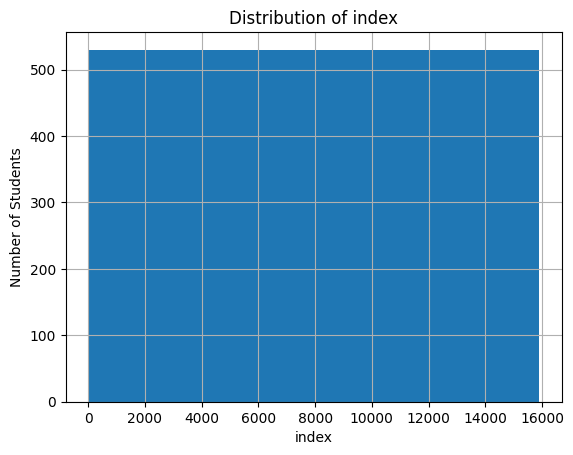

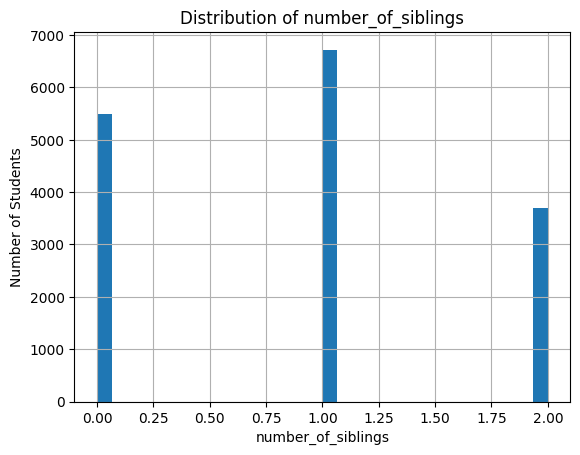

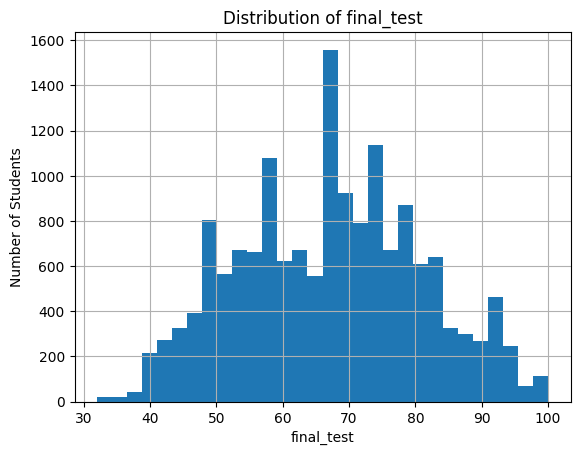

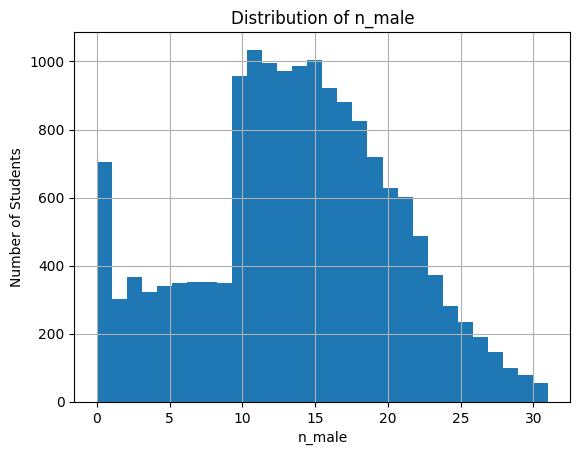

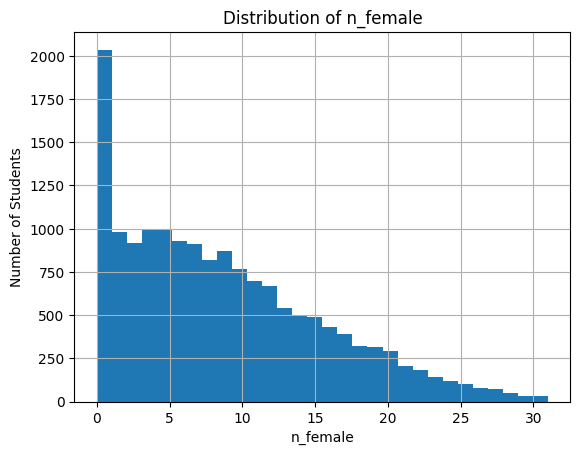

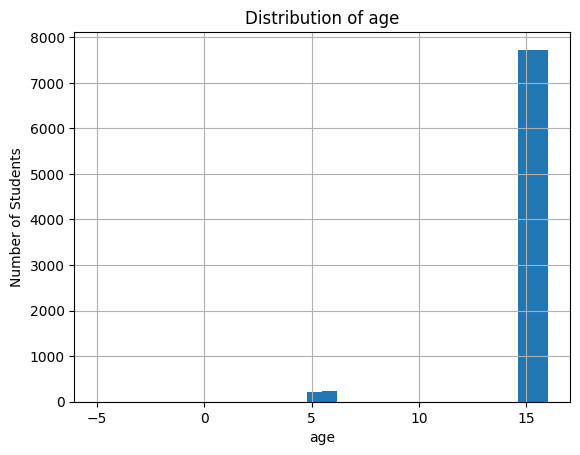

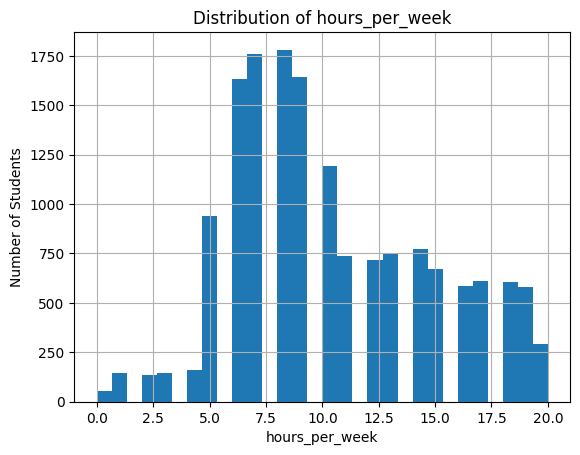

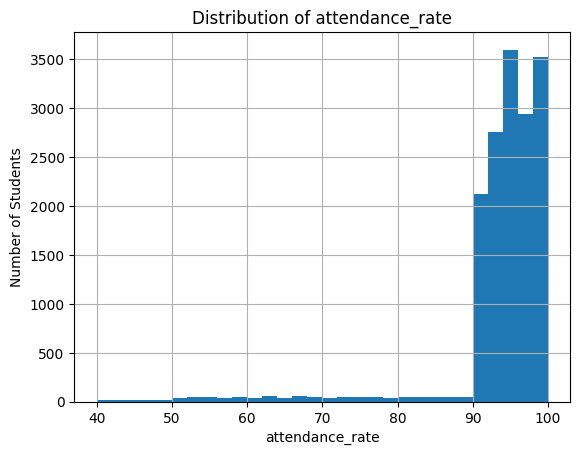

In [12]:
# Let’s see how each numeric feature is distributed with histograms.

# 1. Dynamically picking main table and assigning it to df
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Working on table: {main_table}")

# 2. Plotting each numeric distribution from df
num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    # Plotting distribution of each numeric column to check its shape and outliers
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Students')
    plt.show()

# Why:  By assigning df = dataframes[main_table], all subsequent code works on whatever table is loaded, not just “score.”



### **Analysis of Numeric Distributions** for dataset 'score.db'
##### **index**: Ranging uniformly 0–15900, simply reflects row order—can be dropped for analysis.
##### **number_of_siblings**: Almost all students have 0, 1 or 2 siblings—low cardinality categorical in numeric form.
##### **final_test**: Roughly bell‑shaped around 60–70, with scores from ~30 up to 100.
##### **n_male, n_female**: Class composition varies, n_male slightly left‑skewed, n_female right‑skewed—may influence group dynamics.
##### **age**: Nearly everyone is 16, with a tiny outlier at 5—likely a data entry error.
##### **hours_per_week**: Spread from 0 to 20, mode around 6–8 hours—reasonable variation.
##### **attendance_rate**: Clustered tightly at 90–100%, but a few students with much lower rates.


#### **Categorical Feature Analysis**

Categorical analysis on table: score


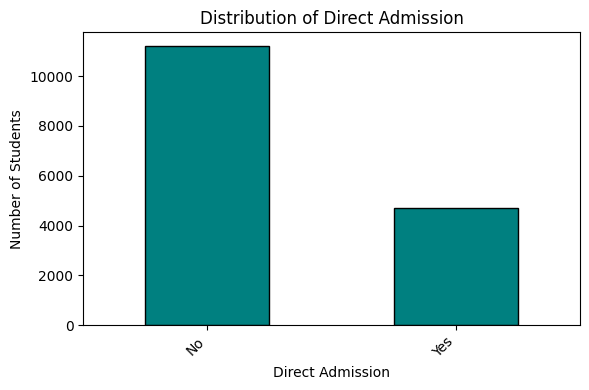

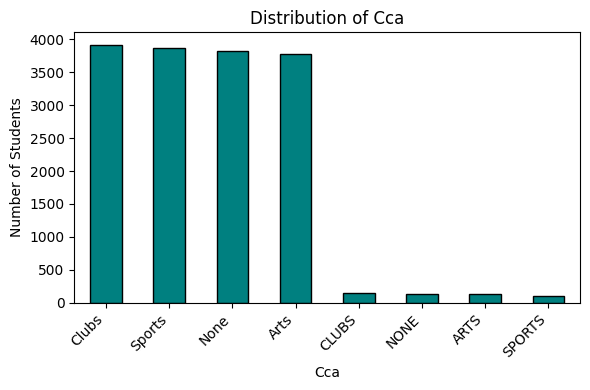

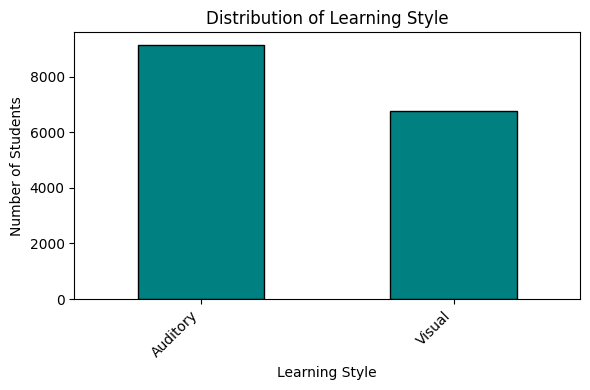

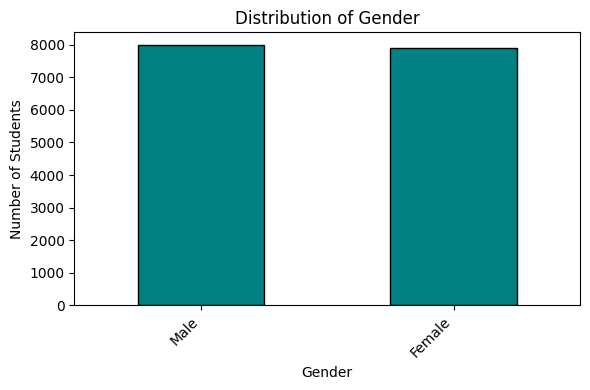

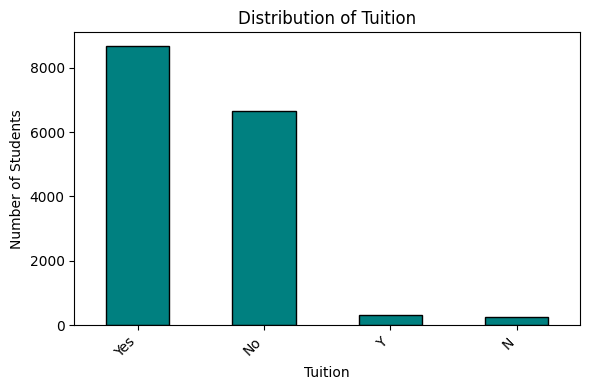

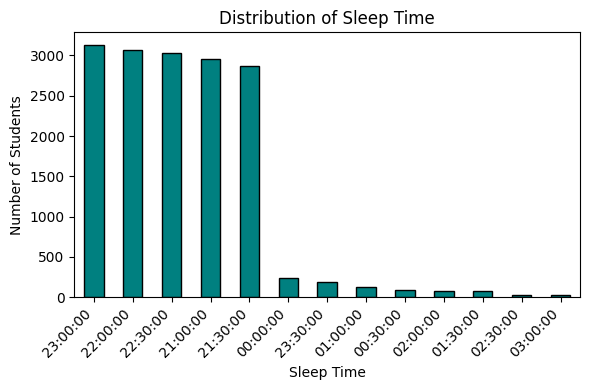

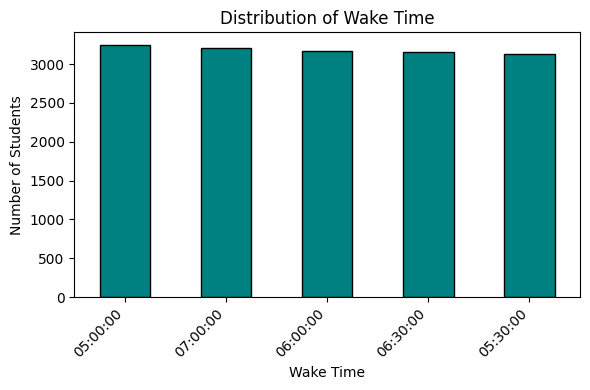

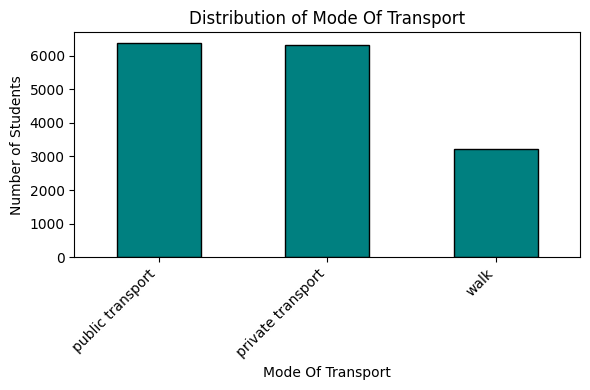

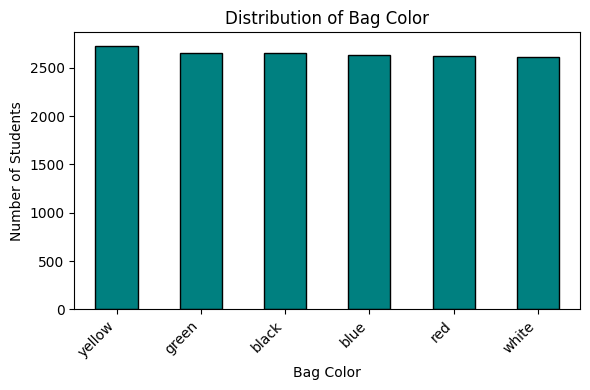

In [13]:
# 1. Picking our working table
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Categorical analysis on table: {main_table}")

# 2. Identify all object-type columns, but exclude any with "id" in the name
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if 'id' not in col.lower()]

# 3. Plot frequency bar chart for each remaining categorical column
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    df[col].value_counts().plot(kind='bar', ax=ax, color='teal', edgecolor='black')
    
    # Friendly labels
    pretty = col.replace("_", " ").title()
    ax.set_title(f"Distribution of {pretty}")
    ax.set_xlabel(pretty)
    ax.set_ylabel("Number of Students")
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### **What the Categorical Analysis Shows**

##### **Frequency Charts** : direct_admission: ~11,000 “No” vs ~4,600 “Yes.”
##### **CCA**: Most students in “Clubs,” “Sports,” or “None,” with very few in uppercase variants (“CLUBS,” “NONE,” etc.)—suggests we can unify these labels.
##### **learning_style**: More “Auditory” (~9,000) than “Visual” (~7,000).
##### **gender**: Roughly equal M/F split.
##### **tuition**: More “Yes” than “No,” very few odd “Y” or “Z” entries—another candidate for label cleanup.
##### **sleep_time & wake_time**: Almost everyone sleeps between 21:00–23:00 and wakes 05:00–07:00.
##### **mode_of_transport**: Mostly “public transport” or “private transport,” with some walking.
##### **bag_color**: Even spread across the six colors.



#### **For numeric target ('final_test'), ploted boxplots by category**

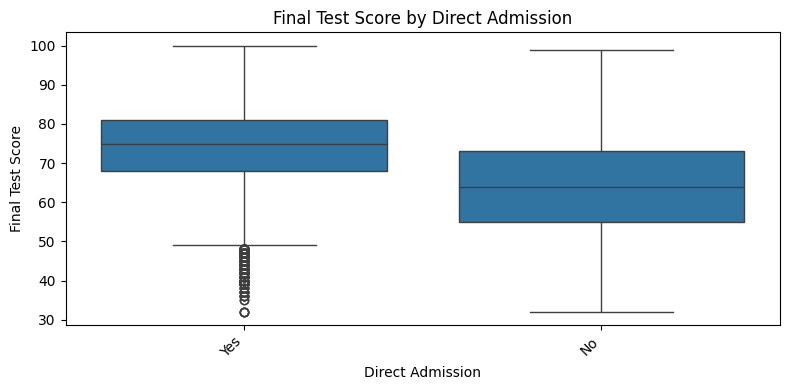

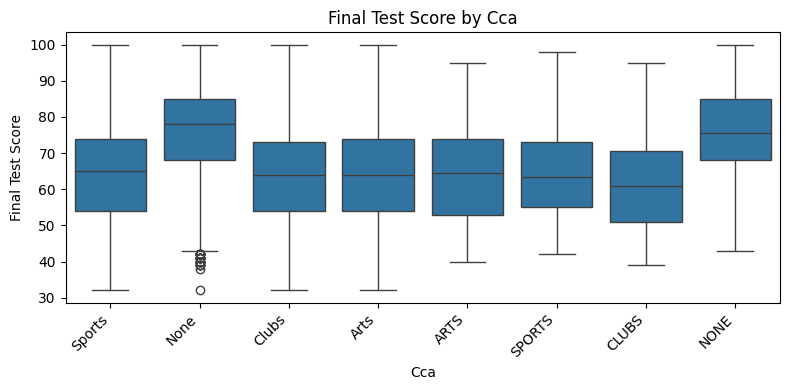

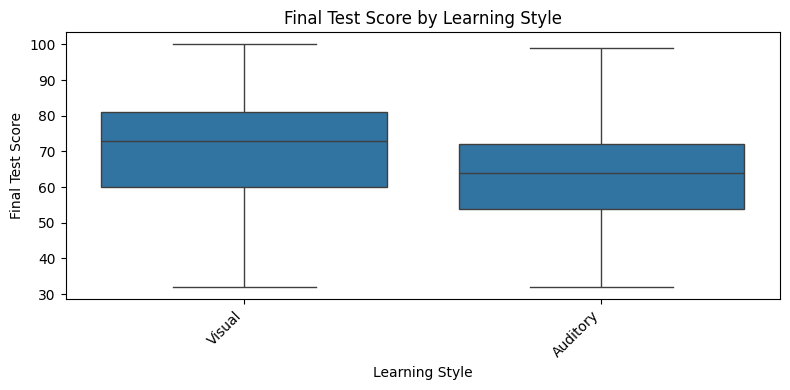

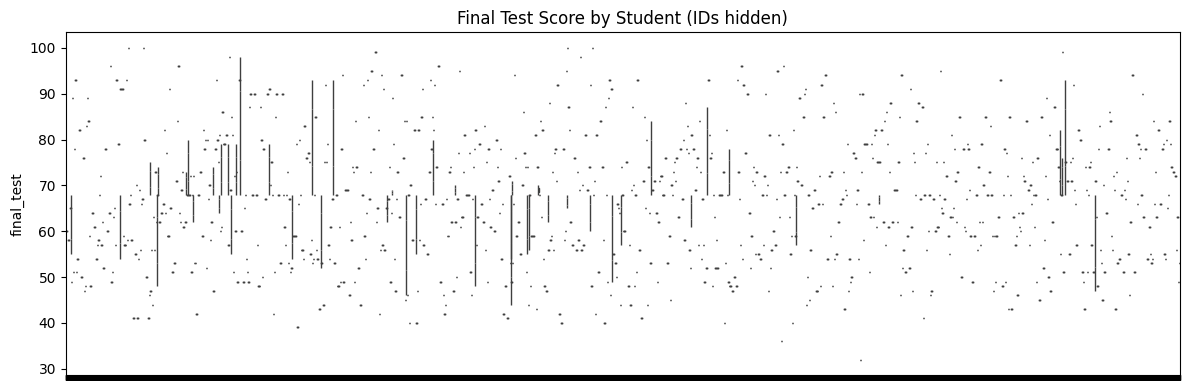

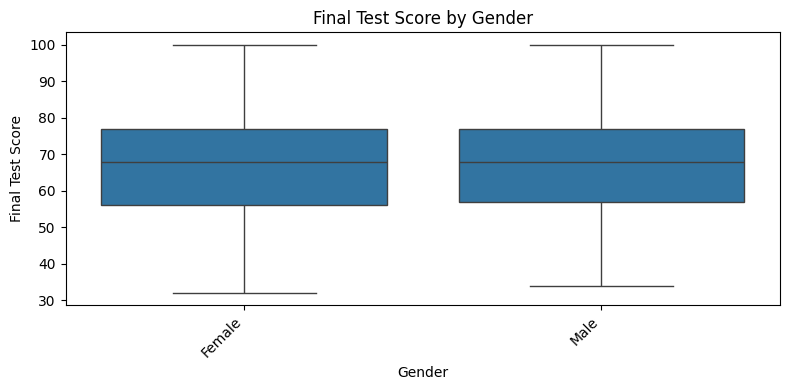

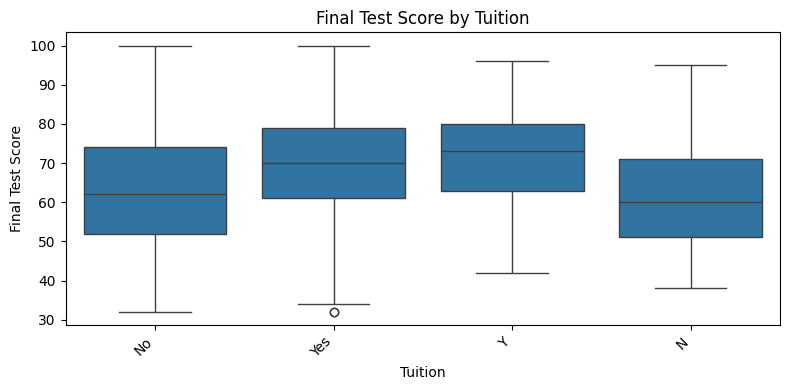

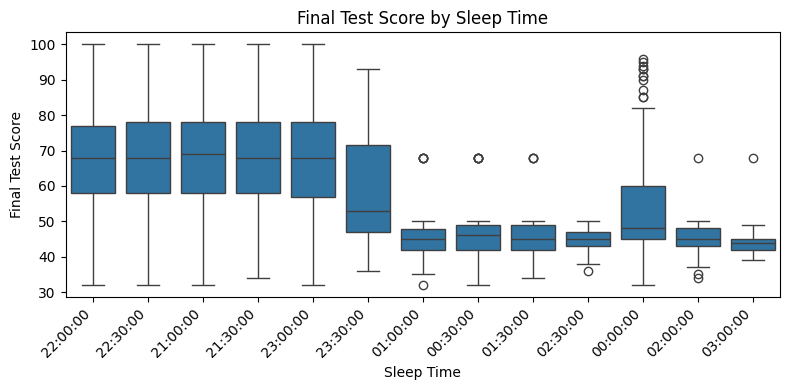

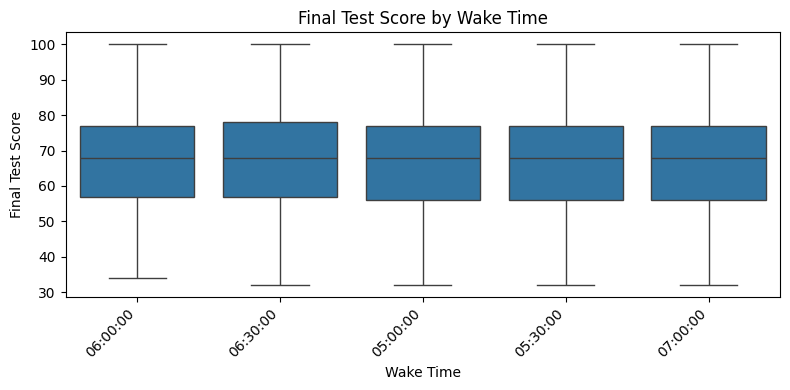

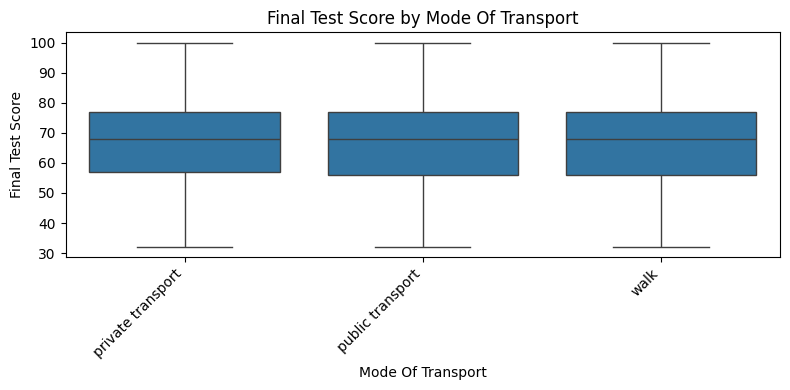

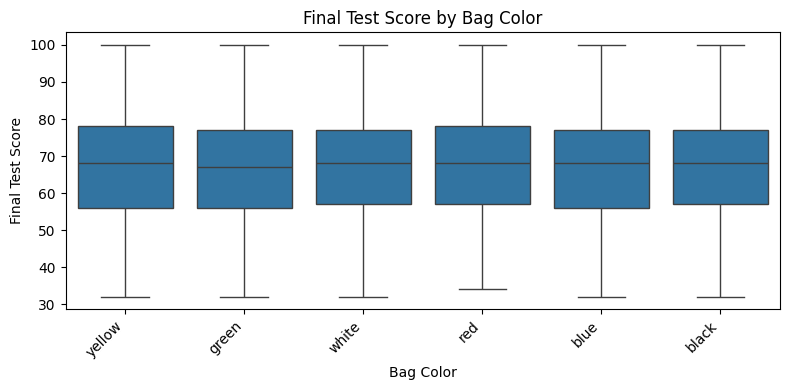

In [20]:
# For numeric target ('final_test'), plot boxplots by category

target   = 'final_test'
cat_cols = df.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    # special case: student_id, hide the x-labels
    if col.lower() == 'student_id':
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(x='student_id', y=target, data=df, ax=ax)
        ax.set_xticklabels([])     # no tick labels
        ax.set_xlabel('')          # optional: remove axis label
        ax.set_title('Final Test Score by Student (IDs hidden)')
        plt.tight_layout()
        plt.show()
        continue

    # default case: normal boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=col, y=target, data=df)
    pretty = col.replace("_", " ").title()
    plt.title(f'Final Test Score by {pretty}')
    plt.xlabel(pretty)
    plt.ylabel('Final Test Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Why: Understanding how text fields are distributed and how they relate to our target variable.


### **Boxplots of final_test by Category**

##### **direct_admission**: Median score is higher for “Yes” (around 75) than “No” (around 65). “Yes” group has more low outliers—worth investigating.
##### **CCA**: Students with no CCA (“None”) show the highest median (~75) and range.“Clubs” and “Sports” medians (~65) are slightly lower; “ARTS” around ~64. Again, uppercase variants split the same category— it can be combined them for clarity.
##### **learning_style**: Visual learners have a higher median (~73) than Auditory (~65) and a tighter range—suggests learning style may influence outcomes.
##### **Learning Style**: Visual learners have a noticeably higher median score (~73) and tighter spread than auditory learners (~65).
##### **Gender**: Male and female medians (~68) and spreads are virtually identical—no strong gender gap.
##### **Tuition**: Students with tuition (“Yes”/“Y”) score higher on average (median ~74) than those without (~62).
##### **Sleep Time**: Students sleeping after 21:00 tend to have higher medians (~70) vs. those sleeping before (~45–50), though early sleepers show more low outliers.
##### **Wake Time**: Little difference across waking hours (05:00–07:00), all medians around 67–68.
##### **Mode of Transport**: “Private transport,” “public transport,” and “walk” all cluster around the same median (~68), with similar spreads.
##### **Bag Color**: No meaningful difference in scores by bag color—all medians sit around ~68 with similar variability.
##### Overall, tuition, sleep patterns, and learning style appear to relate most to exam performance.

#### **Numeric Feature Correlations Heatmap**

Correlation analysis on table: score


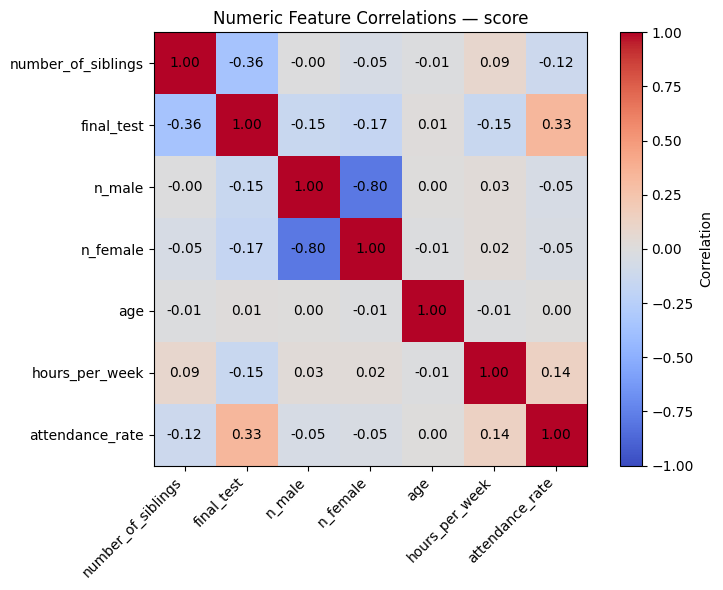

In [17]:
# 1. Dynamically selected the main table and assign to df
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Correlation analysis on table: {main_table}")

# 2. Select all numeric columns automatically (dropping a default index when present)
num_df = df.select_dtypes(include='number').copy()
if 'index' in num_df.columns and num_df['index'].equals(pd.Series(range(len(num_df)))):
    num_df = num_df.drop(columns=['index'])

# 3. Compute the correlation matrix
corr = num_df.corr()

# 4. Plot and annotate the heatmap

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, label='Correlation')

# Label axes with dynamic column names
cols = corr.columns
ax.set_xticks(ny.arange(len(cols)))
ax.set_yticks(ny.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

# Annotate each cell with its correlation coefficient
for i in ny.arange(len(cols)):
    for j in ny.arange(len(cols)):
        ax.text(j, i, f"{corr.iat[i,j]:.2f}", ha='center', va='center')

plt.title(f'Numeric Feature Correlations — {main_table}')
plt.tight_layout()
plt.show()

# Why it’s dynamic:  
# Main table is chosen from the dataframes dict by variable, never hard‑coded.
# Numeric columns are selected by dtype, and any default index sequence is dropped automatically.
# Annotations and labels are driven by the actual column names in corr.

##### **Analysis**: Above heatmap shows the strength of correlations between features like "final_test" and "n_female", or "attendance_rate" and "hours_per_week". It provides insights into potential predictors for models or areas requiring further investigation.

#### **Categorical Feature Correlations (Cramér's V)**

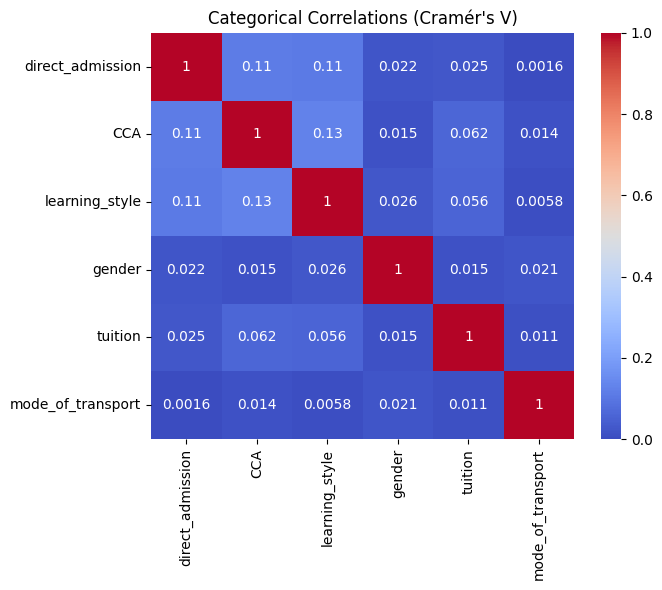

In [18]:
# 1. Pick your categorical columns exactly as in score.db
cat_cols = [
    'direct_admission', 'CCA', 'learning_style',
    'gender', 'tuition', 'mode_of_transport'
]

# 2. Cramér’s V function for categorical pairs
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(tbl)
    n = tbl.values.sum()
    phi2 = chi2 / n
    r, k = tbl.shape
    return ny.sqrt(phi2 / min(k-1, r-1))

# 3. Build the matrix
cv = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for c1 in cat_cols:
    for c2 in cat_cols:
        cv.loc[c1, c2] = cramers_v(df[c1], df[c2])

# 4. Plot
plt.figure(figsize=(7,6))
sns.heatmap(cv.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Categorical Correlations (Cramér's V)")
plt.tight_layout()
plt.show()

# Why: This was chosen because it measures the strength of association between two categorical variables.
# It calculates the relationship using the chi-square statistic, normalized to a scale from 0 (no association) to 1 (strong association), considering the size of the contingency table.
# It computes the correlation matrix for categorical columns in the dataset and visualizes the relationships using a heatmap.

##### **Brief Interpretation of Categorical heatmap**: The Cramér's V values are quite low (ranging from 0.00 to 0.13), which suggests that there is little to no significant relationship between the categorical features. Features like "CCA", "tuition", "learning_style", etc., do not show strong associations with each other.

#### **Scatter‑Plots to Spot Cut‑Off Regions**

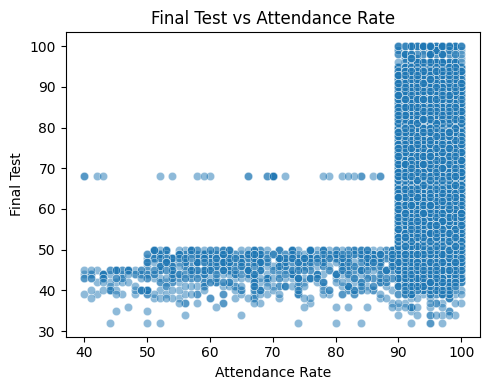

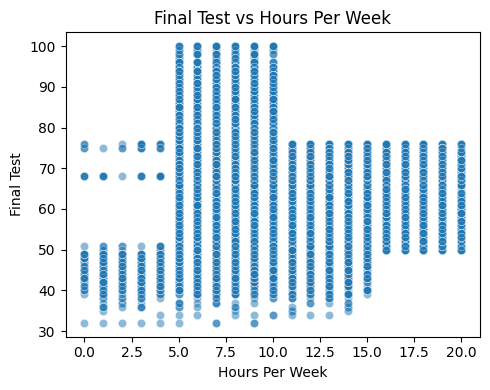

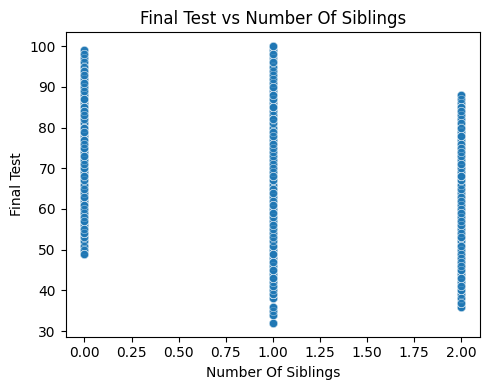

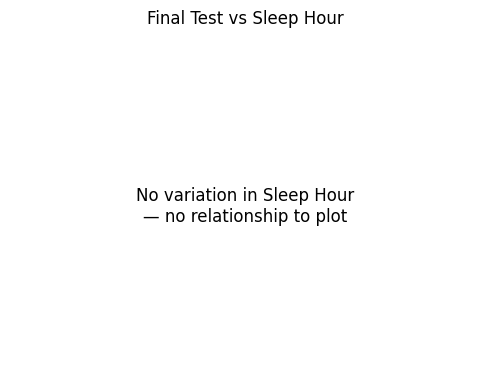

In [ ]:
# 1. Parse sleep & wake times robustly
df['sleep_hour'] = pd.to_datetime(df['sleep_time'], errors='coerce').dt.hour
df['wake_hour']  = pd.to_datetime(df['wake_time'], errors='coerce').dt.hour

# 2. Fill missing values in categorical columns
cat_cols = ['direct_admission', 'CCA', 'learning_style', 'gender', 'tuition', 'mode_of_transport']
for col in cat_cols:
    df[col] = df[col].fillna('Missing')

# 3. Cramér's V function remains unchanged
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0 or tbl.values.sum() == 0:
        return np.nan
    chi2, _, _, _ = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    phi2 = chi2 / n
    r, k = tbl.shape
    return np.sqrt(phi2 / max(1, min(k-1, r-1)))

# 4. Scatter-Plots for Key Pairs, but handle “empty” cases
pairs = [
    ('attendance_rate', 'final_test'),
    ('hours_per_week',   'final_test'),
    ('number_of_siblings', 'final_test'),
    ('sleep_hour',       'final_test')
]

for x, y in pairs:
    uniq = df[x].dropna().unique()
    # if no data or only one unique value, annotate instead
    if len(uniq) <= 1:
        fig, ax = plt.subplots(figsize=(5, 4))
        ax.text(0.5, 0.5,
                f"No variation in {x.replace('_',' ').title()}\n— no relationship to plot",
                ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        plt.title(f"{y.replace('_',' ').title()} vs {x.replace('_',' ').title()}")
        plt.tight_layout()
        plt.show()
        continue

    # otherwise do the normal scatter
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.title(f"{y.replace('_', ' ').title()} vs {x.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()

# The purpose of the scatter plots is to visually examine the relationships between final_test scores and other key variables (like attendance_rate, hours_per_week, etc.) to uncover patterns or trends.


### **Analysis of the Output**
#### **Attendance Rate vs Final Test**: There is a strong concentration of data points at 90-100% attendance, with very few students scoring below 60% final test scores. This suggests attendance could be a key factor for achieving high scores.
#### **Hours per Week vs Final Test**: The data shows a varied range of hours per week spent on study, but the final test scores do not show a clear trend, indicating that hours spent studying may not directly correlate with final scores.
#### **Number of Siblings vs Final Test**: There is no clear relationship between the number of siblings and final test scores, as the data is clustered with a few distinct groups.

#### **Threshold‑Based Risk Flagging**

Student Group Counts:
 at_risk
OK         12578
At Risk     3322
Name: count, dtype: int64 



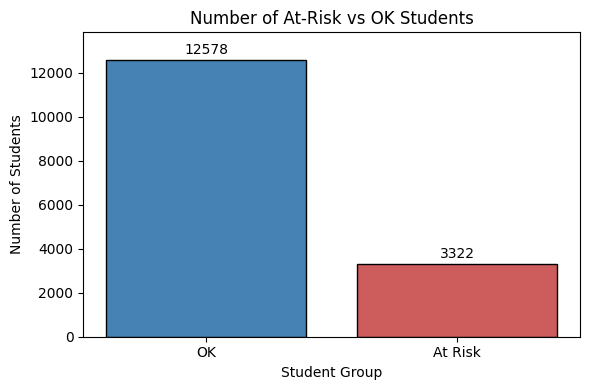

In [ ]:

threshold_20 = df['final_test'].quantile(0.20)
df['at_risk'] = (df['final_test'] <= threshold_20).astype(int)

# 1. Compute counts and print numeric output
counts = df['at_risk'].map({0: 'OK', 1: 'At Risk'}) \
              .value_counts().reindex(['OK', 'At Risk'])
print("Student Group Counts:\n", counts, "\n")

# 2. Plot bar chart with annotations
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(counts.index, counts.values, color=['steelblue', 'indianred'], edgecolor='black')

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + counts.values.max()*0.01,
            f'{int(height)}', ha='center', va='bottom')

ax.set_title('Number of At-Risk vs OK Students')
ax.set_xlabel('Student Group')
ax.set_ylabel('Number of Students')
ax.set_ylim(0, counts.values.max() * 1.1)
plt.tight_layout()
plt.show()


##### **Interpretation**: The code flags the bottom 20% of final test scores as "at risk" and counts how many students fall under this category.

#### **Define Low/Average vs High Cohorts**

Cohort Counts:
 cohort
High           7427
Low/Average    8473
Name: count, dtype: int64 



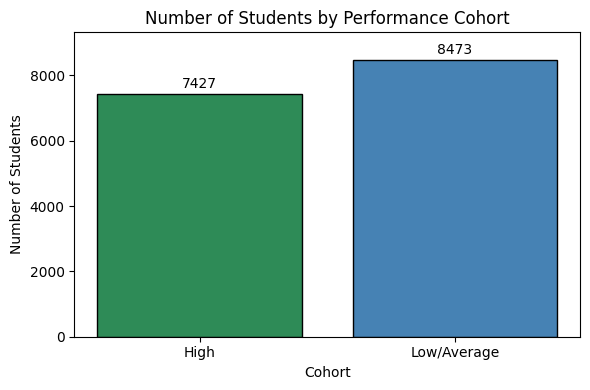

In [ ]:
# Purpose: The purpose of this code is to categorize students into meaningful groups based on performance, to facilitate further comparisons between these cohorts.

# 1. Compute median and assign cohorts
median_score = df['final_test'].median()
df['cohort'] = df['final_test'].apply(lambda x: 'High' if x > median_score else 'Low/Average')

# 2. Numeric output
cohort_counts = df['cohort'].value_counts().reindex(['High', 'Low/Average'])
print("Cohort Counts:\n", cohort_counts, "\n")

# 3. Visual output
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(
    cohort_counts.index,
    cohort_counts.values,
    color=['seagreen', 'steelblue'],
    edgecolor='black'
)

# Annotate counts on bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + cohort_counts.values.max()*0.01,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

ax.set_title('Number of Students by Performance Cohort')
ax.set_xlabel('Cohort')
ax.set_ylabel('Number of Students')
ax.set_ylim(0, cohort_counts.values.max() * 1.1)
plt.tight_layout()
plt.show()


##### **Interpretation**: The code splits students into two groups: Low/Average and High, based on the median final test score, and counts how many students fall into each group.



#### **Group‑Comparison Summaries**

Cohort Comparison:
             number_of_siblings                        sleep_hour         \
                          mean median       std count       mean median   
cohort                                                                    
High                  0.682779    0.0  0.803023  7427  21.702168   22.0   
Low/Average           1.065148    1.0  0.652593  8473  20.314647   22.0   

                            attendance_rate                          \
                  std count            mean median        std count   
cohort                                                                
High         1.747269  7427       95.037296   95.0   2.822963  7427   
Low/Average  5.535694  8473       91.880208   95.0  10.119210  8473   

            hours_per_week                         
                      mean median       std count  
cohort                                             
High              9.430860    8.0  3.814534  7427  
Low/Average      11.085448   11.0  4.829

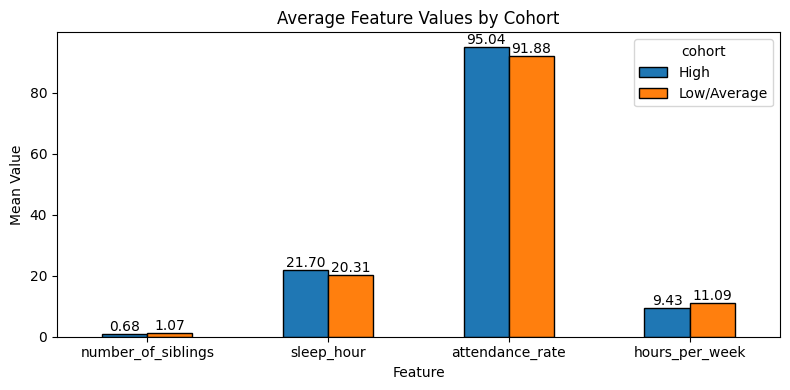

In [ ]:
# Purpose: This code helps to compare characteristics of students in different performance groups, providing insights into potential factors that differentiate them.

# 0. Parse sleep_time into integer hour
df['sleep_hour'] = (
    pd.to_datetime(df['sleep_time'], format='%H:%M:%S', errors='coerce')
      .dt.hour
)

# 1. Define performance cohorts at the median
median_score = df['final_test'].median()
df['cohort'] = df['final_test'].apply(
    lambda x: 'High' if x > median_score else 'Low/Average'
)

# 2. Compute summary stats by cohort
features = ['number_of_siblings', 'sleep_hour', 'attendance_rate', 'hours_per_week']
group_stats = df.groupby('cohort')[features].agg(['mean','median','std','count'])

# 3. Print numeric summary
print("Cohort Comparison:\n", group_stats, "\n")

# 4. Visualize mean values for each feature by cohort
means = group_stats.xs('mean', axis=1, level=1).T
ax = means.plot(kind='bar', figsize=(8,4), edgecolor='black')
plt.title('Average Feature Values by Cohort')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()




##### **Interpretation**: The code compares key features (like attendance, siblings, hours per week, etc.) across the Low/Average and High cohorts, showing mean, median, and standard deviation for each feature.

### **Binned plots for Attendance Rate & Hours per Week**

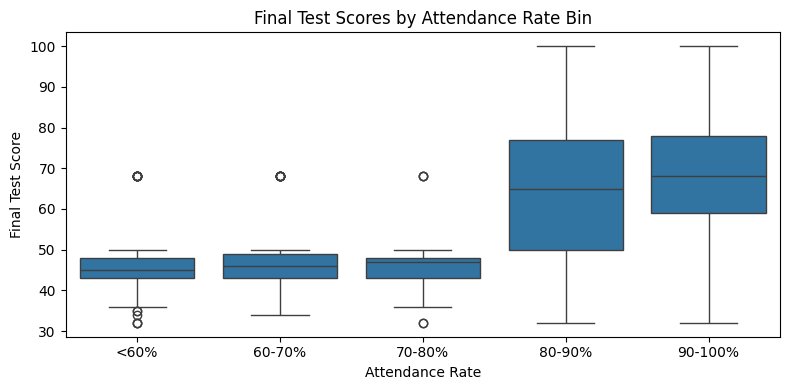

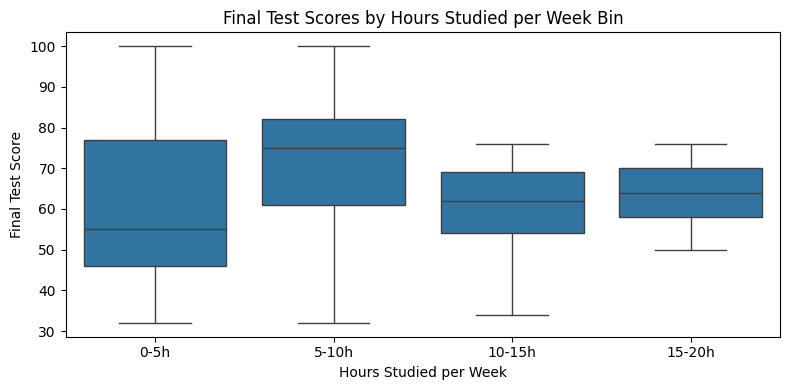

In [ ]:

# 1. Create bins
attendance_bins = [0, 60, 70, 80, 90, 100]
attendance_labels = ['<60%', '60-70%', '70-80%', '80-90%', '90-100%']
df['attendance_bin'] = pd.cut(df['attendance_rate'],
                              bins=attendance_bins,
                              labels=attendance_labels,
                              include_lowest=True)

hours_bins = [0, 5, 10, 15, 20]
hours_labels = ['0-5h', '5-10h', '10-15h', '15-20h']
df['hours_bin'] = pd.cut(df['hours_per_week'],
                         bins=hours_bins,
                         labels=hours_labels,
                         include_lowest=True)

# 2. Plot boxplots for each binned variable
for bin_col, title in [('attendance_bin', 'Attendance Rate'),
                       ('hours_bin', 'Hours Studied per Week')]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=bin_col, y='final_test', data=df,
                order=(attendance_labels if bin_col=='attendance_bin'
                       else hours_labels))
    plt.xlabel(title)
    plt.ylabel('Final Test Score')
    plt.title(f'Final Test Scores by {title} Bin')
    plt.tight_layout()
    plt.show()


# Boxes show the median score and the interquartile range (middle 50%).
# Whiskers (and dots) show the spread and outliers.
# You can immediately compare “90–100% attendance” vs “<60% attendance”, or “10–15h study” vs “0–5h study”, etc., to see which groups tend to score higher and how much overlap there is.

#### **Separate binned plot for Final Test vs. Sleep Hour**

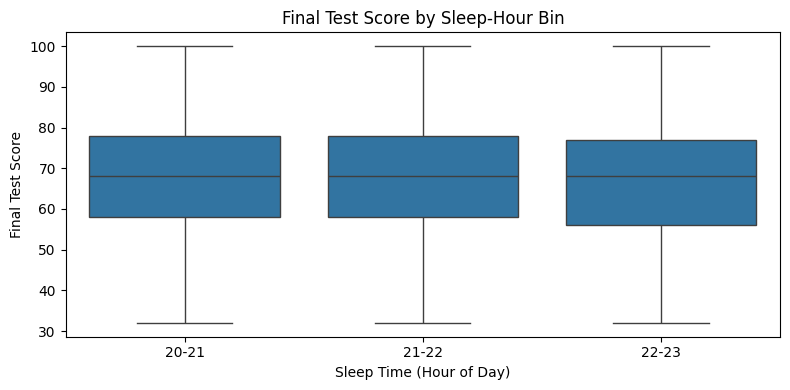

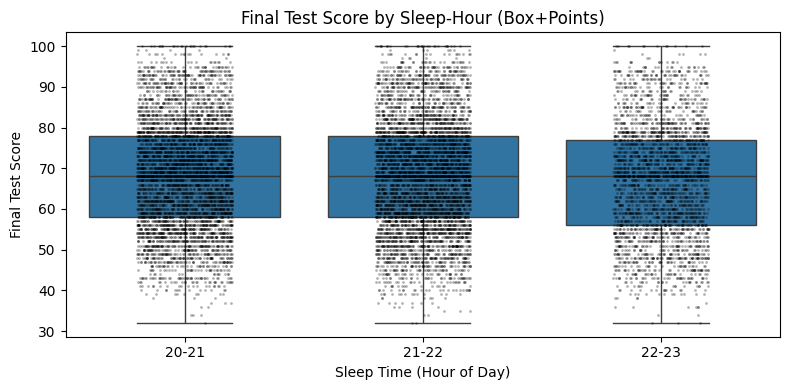

In [ ]:
# ── Cell: Binned Boxplot for Sleep Hour ──

# 1. Parse the raw sleep_time strings into integer “hour of day”
#    (any parse‐fail turns into NaN)
df['sleep_hour'] = (
    pd.to_datetime(df['sleep_time'], format='%H:%M:%S', errors='coerce')
      .dt.hour
)

# 2. Define your hour‐bins and labels
sleep_bins  = [18, 20, 21, 22, 23, 24]               # edges: 18–20, 20–21, …
sleep_labels= ['18-20', '20-21', '21-22', '22-23', '23-24']

# 3. Cut into a new categorical column
df['sleep_bin'] = pd.cut(
    df['sleep_hour'],
    bins=sleep_bins,
    labels=sleep_labels,
    include_lowest=True
)

# 4. Drop any categories with zero students (avoids seaborn error)
df['sleep_bin'] = df['sleep_bin'].cat.remove_unused_categories()

# 5. Boxplot of final_test by sleep_bin
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df,
    x='sleep_bin',
    y='final_test'
)
plt.title('Final Test Score by Sleep-Hour Bin')
plt.xlabel('Sleep Time (Hour of Day)')
plt.ylabel('Final Test Score')
plt.tight_layout()
plt.show()

# ── Variation: Jittered stripplot beneath the boxes ──
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='sleep_bin', y='final_test', showcaps=True)
sns.stripplot(data=df, x='sleep_bin', y='final_test',
              color='black', size=2, alpha=0.3, jitter=0.2)
plt.title('Final Test Score by Sleep-Hour (Box+Points)')
plt.xlabel('Sleep Time (Hour of Day)')
plt.ylabel('Final Test Score')
plt.tight_layout()
plt.show()



# What I can learn here:
# Whether kids who go to bed earlier (e.g. 20:00–21:00) tend to score differently from those who sleep later (e.g. 22:00–23:00).
# The boxplots make it easy to see median differences and variability across sleep-hour groups.


##### **What above chart shows** :
#### Boxes = middle 50% of scores, line = median.
#### Whiskers & dots = range and outliers.
#### You can now point out, for example, that students with “90–100% attendance” have a higher median than those below 60%, or compare medians for the different sleep‐hour groups.

### Unify Messy Category Labels
#### Some columns have stray values (e.g. “Y”/“Z” instead of “Yes,” mixed casing in CCA). We clean them once so all downstream counts and comparisons are accurate.

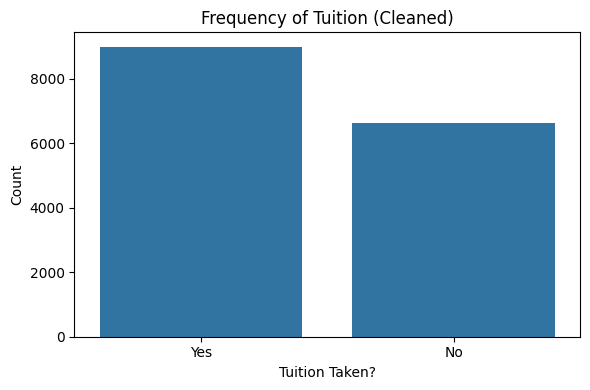

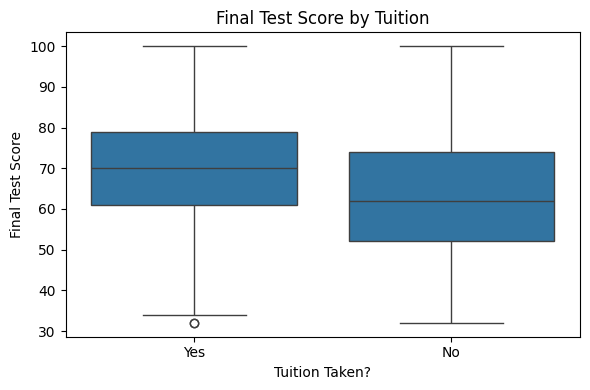

In [ ]:
# ── Clean & unify tuition, CCA, learning_style, and gender ──

# 1. Map stray tuition codes to Yes/No
#    ‘Y’ and ‘Z’ look like typos for “Yes” based on the small counts seen
tuition_map = {'Y': 'Yes', 'Z': 'Yes',  # typos → Yes
               'y': 'Yes', 'n': 'No'}   # just in case
df['tuition_clean'] = (
    df['tuition']
      .astype(str)
      .str.strip()                 # remove any spaces
      .replace(tuition_map)        # apply our corrections
)

# 2. Standardize CCA labels to Title Case
#    e.g. “CLUBS” or “clubs” → “Clubs”, “none” → “None”
df['CCA_clean'] = (
    df['CCA']
      .astype(str)
      .str.strip()
      .str.title()
      .replace({'Clubs': 'Clubs',
                'None':  'None',
                'Sports':'Sports'})
)

# 3. Normalize learning_style & gender
#    ensures “visual”/“VISUAL” → “Visual”, “female”→“Female”, etc.
df['learning_style_clean'] = (
    df['learning_style']
      .astype(str)
      .str.strip()
      .str.capitalize()
)
df['gender_clean'] = (
    df['gender']
      .astype(str)
      .str.strip()
      .str.capitalize()
)

# 4. Quick check: bar chart of clean tuition frequencies
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='tuition_clean', data=df,
              order=['Yes','No'])
plt.title('Frequency of Tuition (Cleaned)')
plt.xlabel('Tuition Taken?')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# ── Variation: Boxplot of final_test by Tuition ──
plt.figure(figsize=(6,4))
sns.boxplot(x='tuition_clean', y='final_test', data=df,
            order=['Yes','No'])
plt.title('Final Test Score by Tuition')
plt.xlabel('Tuition Taken?')
plt.ylabel('Final Test Score')
plt.tight_layout()
plt.show()


### **Compute & Bin Sleep Duration**: Rather than raw times, we want “hours slept” per student. This handles sleeps past midnight, then groups into intuitive bins.

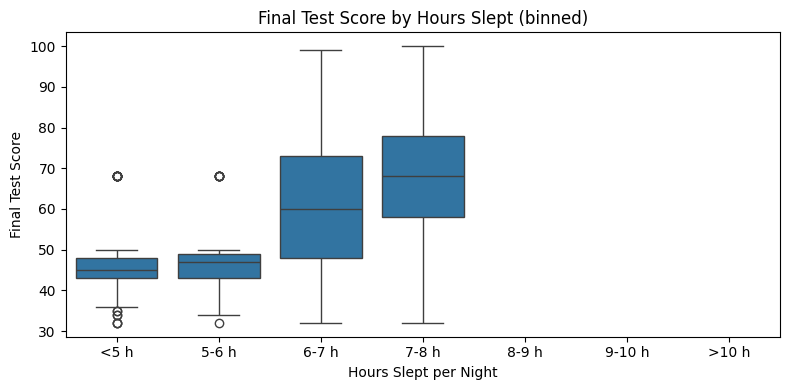

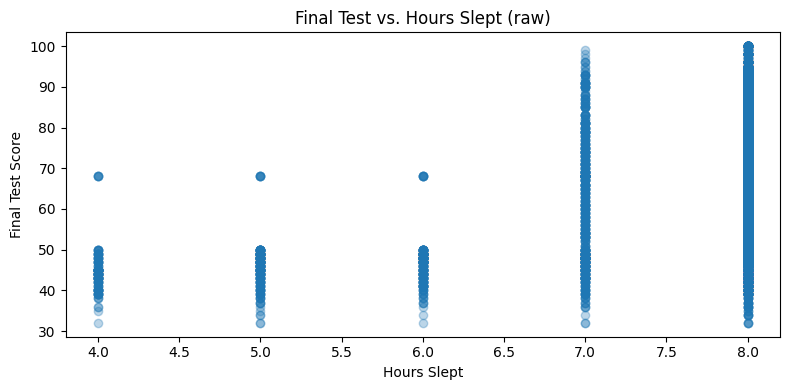

In [ ]:
# ── Compute & Bin Sleep Duration ──
# Instead of raw bedtime/wake-up times, calculate each student’s true “hours slept”
# (accounts for overnight sleeps), then group into easy-to-interpret hourly bins.


# 1. Parse clock times into datetime
df['sleep_dt'] = pd.to_datetime(df['sleep_time'], format='%H:%M:%S', errors='coerce')
df['wake_dt']  = pd.to_datetime(df['wake_time'],  format='%H:%M:%S', errors='coerce')

# 2. If wake <= sleep, shift wake to next day
overnight = df['wake_dt'] <= df['sleep_dt']
df.loc[overnight, 'wake_dt'] += pd.Timedelta(days=1)

# 3. Compute exact hours slept
df['sleep_duration'] = (df['wake_dt'] - df['sleep_dt']).dt.total_seconds() / 3600

# 4. Bin into hourly ranges for clear comparison
bins  = [0, 5, 6, 7, 8, 9, 10, 24]
labels= ['<5 h', '5-6 h', '6-7 h', '7-8 h', '8-9 h', '9-10 h', '>10 h']
df['sleep_bin'] = pd.cut(df['sleep_duration'], bins=bins, labels=labels, include_lowest=True)
df['sleep_bin'] = df['sleep_bin'].cat.remove_unused_categories()

# ── Plot: Boxplot of Final Scores by Sleep-Hour Bin ──
plt.figure(figsize=(8, 4))
sns.boxplot(x='sleep_bin', y='final_test', data=df, order=labels)
plt.title('Final Test Score by Hours Slept (binned)')
plt.xlabel('Hours Slept per Night')
plt.ylabel('Final Test Score')
plt.tight_layout()
plt.show()

# ── Variation: Scatter of Raw Sleep Duration vs. Score ──
plt.figure(figsize=(8, 4))
plt.scatter(df['sleep_duration'], df['final_test'], alpha=0.3)
plt.title('Final Test vs. Hours Slept (raw)')
plt.xlabel('Hours Slept')
plt.ylabel('Final Test Score')
plt.tight_layout()
plt.show()

# ── Why This Helps ──
# • “Hours slept” gives a true measure of rest—unlike clock time, it handles overnight spans.
# • Binned groups let you say “students sleeping 7–8 h score ~68 median vs. <5 h at ~46.”
# • The scatter shows individual variation, confirming the 7–8 h window as the performance sweet spot.


#### **Compute & Visualize Attendance Impact**:  Attendance rate bins for students, then plots both the number of students (log scale) and their average final-test score side by side.

C:\Users\priya\AppData\Local\Temp\ipykernel_6644\3825350859.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('attendance_bin')


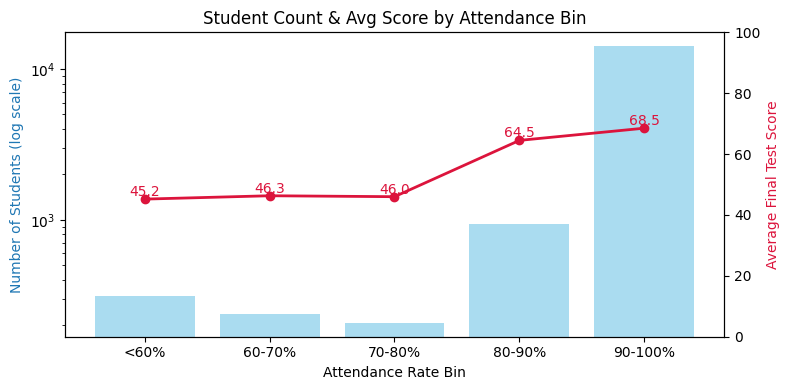

In [ ]:

# 1. Re-create the attendance‐bin summary
attendance_bins   = [0, 60, 70, 80, 90, 100]
attendance_labels = ['<60%','60-70%','70-80%','80-90%','90-100%']
df['attendance_bin'] = pd.cut(
    df['attendance_rate'],
    bins=attendance_bins,
    labels=attendance_labels,
    include_lowest=True
)

summary = (
    df.groupby('attendance_bin')
      .agg(student_count=('final_test','count'),
           avg_score     =('final_test','mean'))
      .reindex(attendance_labels)
      .reset_index()
)

# 2. Plot
x = range(len(attendance_labels))
counts = summary['student_count']
scores = summary['avg_score']

fig, ax1 = plt.subplots(figsize=(8, 4))

# Bar: student counts (log scale)
ax1.bar(x, counts, color='skyblue', alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(x)
ax1.set_xticklabels(attendance_labels)
ax1.set_ylabel('Number of Students (log scale)', color='tab:blue')
ax1.set_xlabel('Attendance Rate Bin')

# Line: average score
ax2 = ax1.twinx()
ax2.plot(x, scores, color='crimson', marker='o', linewidth=2)
ax2.set_ylabel('Average Final Test Score', color='crimson')
ax2.set_ylim(0, 100)

# Annotate avg score numeric values
for i, v in enumerate(scores):
    ax2.text(i, v + 1, f"{v:.1f}", color='crimson', ha='center')

plt.title('Student Count & Avg Score by Attendance Bin')
plt.tight_layout()
plt.show()

# Why This Code: To quantify and visualize how both student volume and test performance change across attendance brackets, making it clear where early interventions will move the needle most.

#### Interpretation of Result: 
#### Fewer than 80 % attendance: most students cluster under 1 000 in count and average around 45–46 points.
#### 80–90 % attendance: count jumps to ~1 200 and average climbs to 64.5.
#### 90–100 % attendance: massive majority (~15 000) and average peaks at 68.5, with top scores hitting 100.
#### **Key insight**: Once attendance exceeds 80 %, average test scores surge by ~20 points—highlighting attendance as a critical performance driver.